In [5]:
#imports
from sunpy.net import hek
from sunpy.net import hek2vso
import matplotlib.pyplot as plt
%matplotlib inline
#matplotlib qt
import shapely
from shapely.wkt import dumps, loads
import numpy as np
import pandas as pd
from shapely.geometry.polygon import LinearRing, Polygon
from datetime import timedelta
import datetime
from sunpy.time import *
from dateutil.parser import parse
import matplotlib.cm as cm
import matplotlib as mpl
from operator import itemgetter
from itertools import groupby
import itertools
import operator
from datetime import timedelta
import time

In [6]:
###### the following is the code ashna has written to filter out single filament eruptions recorded at different wavelengths
client = hek.HEKClient()
h2v = hek2vso.H2VClient()
tstart = '2012/01/01 00:00:00'
tend = '2013/12/31 23:59:59'
event_type = 'ER'
eruptions = client.query(hek.attrs.Time(tstart,tend),hek.attrs.EventType(event_type))
vso_records = h2v.translate_and_query(eruptions[10])

In [3]:
def SetupSunPlotColor(eruptions, trackno, filament):
    plt.grid(True)
    plt.ylabel('ycoord (arcsec)',fontsize=18)
    plt.xlabel('xcoord (arcsec)',fontsize=18)
    plt.axis([-1500, 1500, -1500, 1500])
    cmap = plt.get_cmap('nipy_spectral')
    norm = mpl.colors.Normalize(vmin=0, vmax=3000)
    m = cm.ScalarMappable(norm=norm, cmap=cmap)
    scale= m.to_rgba(trackno)
    longitude = [elem["hpc_x"] for elem in eruptions]  #plotting only those eruptions that are contained in filaments 
    latitude = [elem["hpc_y"] for elem in eruptions]   #plotting only those eruptions that are contained in filaments
    for x,y in zip(longitude, latitude):
        fig=plt.scatter(x, y, color=next(colors),s=50)
    Circle1 = plt.Circle((0,0), radius=1000, linestyle='solid', linewidth=2, fill=False)
    fig1 = plt.gcf()
    fig1.gca().add_artist(Circle1)
    fig1.set_size_inches(10.5,10.5)
    ax = fig1.add_subplot(111)
    ax.set_aspect('equal')
    ax.tick_params(axis='both', which='major', labelsize=14)
    plt.title('Filament Eruptions and Tracks on the Sun, October 2013')
    plot_polygon=plt.Polygon(loads(filament).exterior,color=scale,linewidth=1,fill=None)
    fig1.gca().add_artist(plot_polygon) 

In [17]:
times=[elem["event_starttime"] for elem in eruptions] 
result=[]
indices=[]
### the following loop will remove identical eruptions that have been recorded at different wavelengths by sorting with time
for element in times:
    if element not in result:
        indices.append((times.index(element)))
        result.append(element)
filtered=[eruptions[i] for i in indices]
print len(filtered)

10316


100 None
101 None
102 None
103 None
104 None
105 None
106 None
107 None
108 None
109 None
110 None
111 None
112 -1.49957001209
113 None
114 None
115 None
116 None
117 None
118 None
119 None
120 -0.220855996013
121 None
122 None
123 None
124 None
125 None
126 None
127 None
128 None
129 None
130 None
131 None
132 None
133 None
134 None
135 None
136 None
137 None
138 None
139 None
140 None
141 None
142 None
143 None
144 None
145 None
146 None
147 None
148 None
149 None
150 -2.26553988457
151 None
152 1.5021699667
153 None
154 None
155 None
156 None
157 None
158 None
159 None
160 None
161 None
162 None
163 None
164 None
165 None
166 None
167 -1.25653004646
168 None
169 None
170 None
171 None
172 None
173 None
174 -3.57557010651
175 None
176 None
177 None
178 5.23251008987
179 None
180 None
181 None
182 None
183 None
184 None
185 None
186 None
187 None
188 None
189 None
190 None
191 None
192 None
193 None
194 None
195 None
196 None
197 -0.600937008858
198 None
199 None


(array([   4.,   33.,  263.,  500.,  588.,  478.,  515.,  151.,   22.,    4.]),
 array([-10.5951004 ,  -8.41186037,  -6.22862034,  -4.04538031,
         -1.86214027,   0.32109976,   2.50433979,   4.68757982,
          6.87081985,   9.05405989,  11.23729992]),
 <a list of 10 Patch objects>)

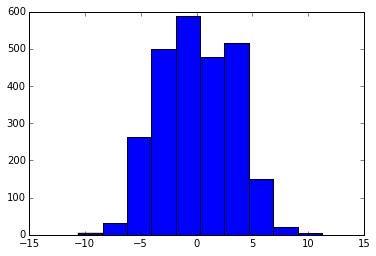

In [27]:
trans_speed = [elem["outflow_transspeed"] for elem in eruptions]
#for i in range(100, 200):
    #print i, trans_speed[i]
    #print type(trans_speed[0])

trans_speed= filter(None, trans_speed)
plt.hist(trans_speed)

(array([  8.36200000e+03,   1.07600000e+03,   3.69000000e+02,
          1.60000000e+02,   9.50000000e+01,   3.70000000e+01,
          1.80000000e+01,   1.10000000e+01,   5.00000000e+00,
          6.00000000e+00]),
 array([   3.6300199 ,   13.48531778,   23.34061565,   33.19591353,
          43.0512114 ,   52.90650928,   62.76180716,   72.61710503,
          82.47240291,   92.32770078,  102.18299866]),
 <a list of 10 Patch objects>)

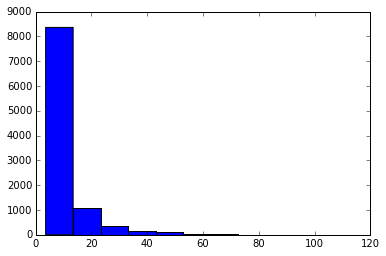

In [28]:
intensity = [elem["intensmax"] for elem in eruptions]
#for i in range(100,200):
    #print i, intensity[i]
intensity= filter(None, intensity)
plt.hist(intensity)    

100 None
101 None
102 None
103 None
104 None
105 None
106 None
107 None
108 None
109 None
110 None
111 None
112 None
113 None
114 None
115 None
116 None
117 None
118 None
119 None
120 None
121 None
122 None
123 None
124 None
125 None
126 None
127 None
128 None
129 None
130 None
131 None
132 None
133 None
134 None
135 None
136 None
137 None
138 None
139 None
140 None
141 None
142 None
143 None
144 None
145 None
146 None
147 None
148 None
149 None
150 None
151 None
152 None
153 None
154 None
155 None
156 None
157 None
158 None
159 None
160 None
161 None
162 None
163 None
164 None
165 None
166 None
167 None
168 None
169 None
170 None
171 None
172 None
173 None
174 None
175 None
176 None
177 None
178 None
179 None
180 None
181 None
182 None
183 None
184 None
185 None
186 None
187 None
188 None
189 None
190 None
191 None
192 None
193 None
194 None
195 None
196 None
197 None
198 None
199 None


ValueError: x must have at least one data point

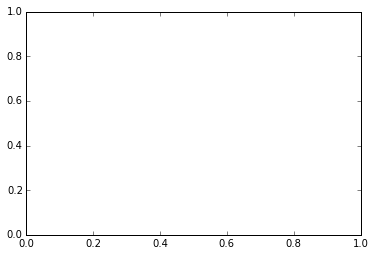

In [33]:
areas = [elem["area_atdiskcenteruncert"] for elem in eruptions]
for i in range(100,200):
    print i, areas[i]
areas= filter(None, areas)
plt.hist(areas)    

In [35]:
keys=eruptions[0]
for item in keys: 
    print item

concept
frm_versionnumber
hrc_coord
hpc_bbox
area_atdiskcenter
event_mapurl
event_c1error
obs_dataprepurl
hgc_coord
frm_identifier
event_expires
intensmean
boundbox_c2ur
event_coordunit
gs_thumburl
obs_meanwavel
bound_ccnsteps
outflow_width
hgs_coord
bound_chaincode
frm_daterun
intensmedian
bound_ccstartc1
frm_paramset
bound_ccstartc2
event_coord2
event_coord3
outflow_widthunit
event_coord1
event_importance
kb_archivdate
event_title
hrc_r
hgc_bbox
skel_chaincode
intenstotal
hrc_a
area_atdiskcenteruncert
event_probability
gs_movieurl
event_description
eventtype
ar_polarity
obs_channelid
ar_mcintoshcls
frm_institute
frm_contact
ar_noaaclass
boundbox_c1ur
hgs_boundcc
boundbox_c2ll
area_unit
area_raw
intensskew
hpc_coord
frm_name
obs_levelnum
area_uncert
ar_zurichcls
active
event_importance_num_ratings
obs_includesnrt
event_testflag
hpc_y
hpc_x
hpc_boundcc
event_score
obs_lastprocessingdate
refs_orig
ar_numspots
intensvar
outflow_speed
event_avg_rating
frm_url
ar_compactnesscls
comment_cou

In [5]:
fi_tracked = pd.read_csv('FIDustinTracked24Mo.txt',delimiter='\t')
fi_tracked.head()
tracks=fi_tracked['Track No.']
good_tracks = fi_tracked.groupby('Track No.').filter(lambda x: len(x['Track No.']) >= 3, dropna=False) 

# Loops through both eruption data and track data. Checks if any track polygons contain an eruption point. Then checks if these eruptions can be found in +/- 12 hours of the polygon.

In [6]:
margin = datetime.timedelta(hours=12)             
FT_time = good_tracks['HEK_time']    #Finds the time stamps for all the filaments
FE_time = [elem["event_starttime"] for elem in filtered] #Finds the time stamps for all the eruptions
FT_poly = good_tracks['HPC_BB_Poly']    #Finds the polygon coordinates for the good_tracks
FE_coords = [elem["hpc_coord"] for elem in filtered] #Finds the point coordinates for the filtered eruptions 
contained=[]    ####This will be a helpful list for finding which tracks have eruptions contained inthem 
loopnumb=[]    #to keep track of the eruption number 
practice=[]
start = time.time()
for j in range(0, len(FE_coords)):    #looks at all possible eruptions 
    FET=(parse_time(FE_time[j])) 
    FE_point_obj = loads(FE_coords[j]) #creates a shapely point object
    for i in range(0, len(FT_poly)):  #looks at all possible tracks 
        if pd.isnull(FT_poly[i]):   #skips over tracks of less than 3 elements 
            pass
        else:   
            FLT=parse(FT_time[i]) 
            FT_poly_obj = loads(FT_poly[i])   #creates polygon object from track
            if FT_poly_obj.contains(FE_point_obj) and FET-margin <= FLT <= FET + margin: #checks if point is contained in polygon 
                contained.append(good_tracks['Track No.'][i])   #finds the track number of these tracks 
                loopnumb.append(j)
                print FE_time[j]
                if good_tracks['Track No.'][i] == 16.0:
                    practice.append((FE_time[j], good_tracks['Track No.'][i]))
                print "This means that the eruption point is contained in the filament polygon"
                print j,i  #the indicies of the eruption and filament track
erup=[indices[i] for i in loopnumb]   #getting the eruption index from a list of possible indices
filtered2=[eruptions[i] for i in erup]   #eruption data that correspond to being contained in a filament 
totaltime = start - time.time()
print 'This loop took', totaltime%60

2012-01-04T01:59:44
This means that the eruption point is contained in the filament polygon
36 104
2012-01-12T21:02:08
This means that the eruption point is contained in the filament polygon
135 217
2012-01-22T08:00:04
This means that the eruption point is contained in the filament polygon
265 413
2012-03-08T02:40:16
This means that the eruption point is contained in the filament polygon
645 1272
2012-03-16T20:00:16
This means that the eruption point is contained in the filament polygon
793 1373
2012-05-01T17:39:28
This means that the eruption point is contained in the filament polygon
1271 2229
2012-05-04T13:40:32
This means that the eruption point is contained in the filament polygon
1322 2330
2012-05-19T12:39:44
This means that the eruption point is contained in the filament polygon
1601 2713
2012-06-14T03:19:44
This means that the eruption point is contained in the filament polygon
1902 3558
2012-06-29T09:00:00
This means that the eruption point is contained in the filament polygon

In [7]:
good_polygons=[] #Trying to find polygon data for the filaments that contained eruptions and at a good time 
for i in range(len(good_tracks)): #iterating through the whole list of tracks 
    if good_tracks['Track No.'][i] in contained:  #if the track number is in the lists created previously 
         good_polygons.append((good_tracks['Track No.'][i],good_tracks['HPC_BB_Poly'][i]))#append the polygon data to good polygons

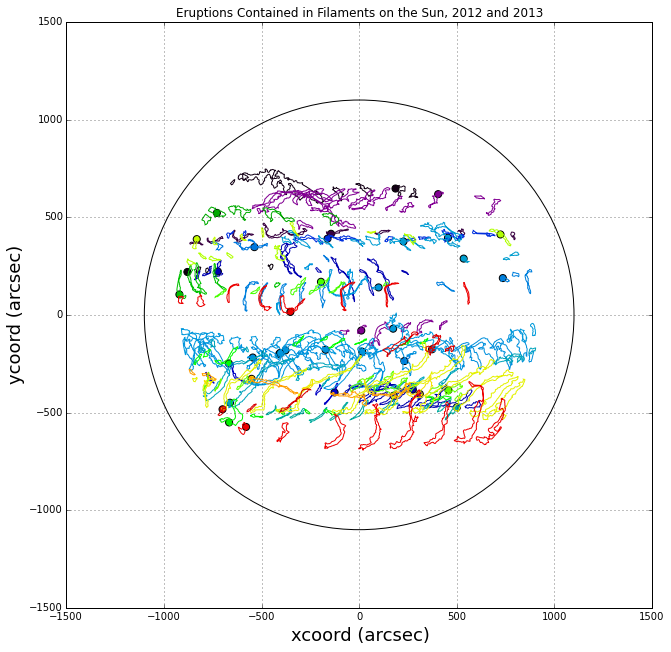

In [8]:
####makes a colorscale for the eruptions
colorscale=[]
norm = mpl.colors.Normalize(vmin=0, vmax=6700)
cmap = plt.get_cmap('nipy_spectral')
m = cm.ScalarMappable(norm=norm, cmap=cmap)
for item in contained: #plotting those filaments that have eruptions contained within them
    scale1= m.to_rgba(item) 
    colorscale.append(scale1)

####plots eruptions/sun 
plt.grid(True)
plt.ylabel('ycoord (arcsec)',fontsize=18)
plt.xlabel('xcoord (arcsec)',fontsize=18)
plt.axis([-1500, 1500, -1500, 1500])
longitude = [elem["hpc_x"]for elem in filtered2]
latitude = [elem["hpc_y"] for elem in filtered2]
fig=plt.scatter(longitude,latitude,c= colorscale,s=50)
Sun=plt.Circle((0,0), radius=1100, color='black', fill=False)
plt.gcf().gca().add_artist(Sun)
plt.title('Eruptions Contained in Filaments on the Sun, 2012 and 2013')
fig1 = plt.gcf()
fig1.set_size_inches(10.5,10.5)
ax = fig1.add_subplot(111)
ax.set_aspect('equal') 

####plots filament tracks 
for poly in good_polygons: 
    scale=m.to_rgba(poly[0])
    plot_polygon=plt.Polygon(loads(poly[1]).exterior,color=scale,linewidth=1,fill=None)
    fig1.gca().add_artist(plot_polygon)
plt.show()

In [9]:
print len(filtered2)

40


   ###new updated eruption list for each track 
erupting_tracks =[]
tot=[]
unique=[]
erupind=[]
close_unique=np.unique(close)
for tracks in close_unique:
    tot.append(unique)
    unique=[]
    for i in range(0, len(good_tracks)):
        if tracks == good_tracks['Track No.'][i]:
            unique.append(i)
            
for item in tot:
    colorscale2=[]
    norm = mpl.colors.Normalize(vmin=0, vmax=6700)
    cmap = plt.get_cmap('nipy_spectral')
    m = cm.ScalarMappable(norm=norm, cmap=cmap)
    for thing1 in close: #plotting those filaments that have eruptions contained within them
        scaleR= m.to_rgba(thing1) 
        colorscale2.append(scaleR)
####plots eruptions/sun
    plt.grid(True)
    plt.ylabel('ycoord (arcsec)',fontsize=18)
    plt.xlabel('xcoord (arcsec)',fontsize=18)
    plt.axis([-1500, 1500, -1500, 1500])
    fig1 = plt.gcf()
    Sun=plt.Circle((0,0), radius=1100, color='black', fill=False)
    plt.gcf().gca().add_artist(Sun)
    fig1.set_size_inches(10.5,10.5)
    ax = fig1.add_subplot(111)
    ax.set_aspect('equal')
        ##############################
    for i in range(0, len(item)):
        j=item[i]
        trnum=  good_tracks['Track No.'][j]
        stime=  good_tracks['HEK_time'][j]
        print stime
        if i == 0:
            first_poly = loads(good_tracks['HPC_Center'][j])
        for thing1 in corresponding:
            if thing1[0] == trnum:
                erupind.append(thing1[1])
        verup=[indices[i] for i in erupind]   #getting the eruption index from a list of possible indices
        erupind=[]
        filtered4=[eruptions[k] for k in verup]
        longitude = [elem["hpc_x"]for elem in filtered4]
        latitude = [elem["hpc_y"] for elem in filtered4]
        erup_coord = [elem["hpc_coord"] for elem in filtered4]
        erup_t = [elem["event_starttime"] for elem in filtered4]
        for thing2 in erup_t:
            tim = (parse_time(thing2))
        for thing3 in erup_coord:
            erup_point = loads(thing3)
        if erup_point.x < first_poly.x:  #finding if the eruption occurs before the first polygon
            plt.close()
        else:
            if abs(erup_point.y - first_poly.y) > 300:
                plt.close()
            else:
                erupting_tracks.append(trnum)
                plt.text(1400,1400,str(erup_t))
                fig=plt.scatter(longitude,latitude, c = 'grey',s=50)
                scale2=m.to_rgba(good_tracks['Track No.'][j])
                plot_polygon=plt.Polygon(loads(good_tracks['HPC_BB_Poly'][j]).exterior,color=scale2,linewidth=1,fill=None)
                fig1.gca().add_artist(plot_polygon)
                plt.title('Track Number %(Trackno)d at %(starttime)s on the Sun.' % {"Trackno" : trnum, "starttime": stime})
    plt.show()
for item in contained: 
    if item not in erupting_tracks:
        erupting_tracks.append(item)
erupting_tracks= np.unique(erupting_tracks)

In [ ]:
####reads the in the confirmed erupting tracks from the FILAMENT ERUPTION HEK metadata, and checks to see if they intersect the results from this method
url_erupting = '/Users/ashnaaggarwal/Documents/Filament_Tracking/Filament_tracking/EruptingTracks_List_2012_2013.csv'
track_files = pd.read_csv(url_erupting)
print track_files

     Erupting_TrackNo
0                  15
1                  57
2                 110
3                 144
4                 171
5                 193
6                 200
7                 338
8                 356
9                 381
10                382
11                432
12                467
13                523
14                563
15                699
16                705
17                768
18                783
19                965
20                990
21                991
22               1037
23               1058
24               1082
25               1107
26               1131
27               1152
28               1180
29               1182
..                ...
96               5144
97               5178
98               5183
99               5196
100              5287
101              5305
102              5335
103              5428
104              5453
105              5559
106              5562
107              5593
108              5599
109       

# The following kernel looks at both "good tracks" (tracks with 3 or more elements) and "filtered" eruption data (data that does not occur at multiple wavelengths). The code loops through the list of filtered eruptions and checks if any eruption box intersects with a good track (also iterated through with a loop).

In [ ]:
margin = datetime.timedelta(hours=12)             
FT_time = good_tracks['HEK_time']    #Finds the time stamps for all the filaments
FE_time = [elem["event_starttime"] for elem in filtered] #Finds the time stamps for all the eruptions
FT_poly = good_tracks['HPC_BB_Poly'] 
FE_box = [elem["hpc_bbox"] for elem in filtered] 
FE_coords = [elem["hpc_coord"] for elem in filtered]
intersected=[] #the tracks that intersect with eruption boxes
event=[]  #eruption point 
manypoly=[] #center point of filament
erupno=[]   #eruption's number 
time_erup=[]
start = time.time()
########## to only plot certain eruptions
for j in range(0, len(FE_box)):    #looks at all possible eruptions 
    FET=(parse_time(FE_time[j]))
    FE_box_obj = loads(FE_box[j]) #creates a shapely box object object
    FE_point_obj=loads(FE_coords[j])
    for i in range(0, len(FT_poly)):  #looks at all possible tracks 
        if pd.isnull(FT_poly[i]):   #skips over tracks of less than 3 elements 
            pass
        else:    
            FLT=parse(FT_time[i])
            FT_poly_obj = loads(FT_poly[i])   #creates polygon object from track
            if FT_poly_obj.intersects(FE_box_obj) and FET-margin <= FLT <= FET + margin: #checks if box intersects with polygon
                intersected.append(good_tracks['Track No.'][i])   #finds the track number of these tracks 
                #print "This means that the eruption bounding box intersects with the filament polygon"
                manypoly.append(loads(good_tracks['HPC_Center'][i]))  #grabs the center point coords of the filament 
                event.append(FE_point_obj)      #grabs the eruption point 
                erupno.append(j)
                time_erup.append(FET)
                print "This means that the eruption box is intersected with the filament polygon"
                print j,i  #the indicies of the eruption and filament track
totaltime = start - time.time()
print 'This loop took', totaltime%60
multi=zip(intersected, event, manypoly, erupno, time_erup)

This means that the eruption box is intersected with the filament polygon
0 0
This means that the eruption box is intersected with the filament polygon
2 14
This means that the eruption box is intersected with the filament polygon
26 38
This means that the eruption box is intersected with the filament polygon
33 2
This means that the eruption box is intersected with the filament polygon
33 6
This means that the eruption box is intersected with the filament polygon
33 7
This means that the eruption box is intersected with the filament polygon
33 21
This means that the eruption box is intersected with the filament polygon
33 28
This means that the eruption box is intersected with the filament polygon
33 29
This means that the eruption box is intersected with the filament polygon
33 51
This means that the eruption box is intersected with the filament polygon
33 52
This means that the eruption box is intersected with the filament polygon
34 28
This means that the eruption box is intersecte

In [ ]:
dist=[]  ###will be a list of distances between the eruptions and center of the filaments 
final_erup=[]   #eruption's number
practice=[]
for item in multi:
     dist.append(item[1].distance(item[2]))

multi3=zip(intersected, event, dist, erupno, time_erup) #This is what you did
test = pd.DataFrame(multi3) #Turn multi3 into a pandas dataframe
columns=['Track No.','Eruption Coord','Distance to filament','Eruption No.', 'Eruption Time'] #Name the columns so they are easier to deal with
test.columns=columns
idx = test.groupby(['Track No.'])['Distance to filament'].transform(min) == test['Distance to filament']
idx2 = test.groupby(['Eruption No.'])['Distance to filament'].transform(min) == test['Distance to filament']
only_min=test[idx & idx2]
only_min = only_min.sort('Track No.')
close=[]   #those tracks closest to the eruptions 
corresponding=[] ### just to know which tracks correspond to which eruption 
for index, item in only_min.iterrows():
    close.append(item[0])   #for the tracks 
    final_erup.append(item[3])   #for the eruptions 
    corresponding.append((item[0], item[3]))   # to see which tracks correspond to which eruptions
    practice.append((item[4], item[0]))
#print corresponding    
    
erupbox_with_track=[indices[i] for i in final_erup]
filtered3=[eruptions[i] for i in erupbox_with_track]

print len(only_min)

In [1]:
print len(intersected)

NameError: name 'intersected' is not defined